# Fit Fragments (CDK2)

### Libraries

In [1]:
import sys

sys.path.append("..")

In [2]:
import open3d as o3d
import numpy as np
import seaborn as sns
import pandas as pd

from numpy.random import default_rng
from scipy.spatial.transform import Rotation as R

import re, os
from io import StringIO

import py3Dmol

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from rdkit.Chem import rdMolTransforms
from rdkit.Chem.Draw import MolDrawing, DrawingOptions

PandasTools.InstallPandasTools()
PandasTools.RenderImagesInAllDataFrames(images=True)

import ipywidgets as widgets
from IPython.display import HTML

import copy

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


INFO - 2021-08-19 14:58:28,519 - __init__ - Enabling RDKit 2021.03.3 jupyter extensions


In [3]:
from score_pcd import fit_and_score

## SENSAAS

### Imatinib (Test)

In [4]:
%%bash
export PATH=${PWD}/../../sensaas:${PATH}
python ../../sensaas/meta-sensaas.py ligands/imatinib.sdf ligands/imatinib_parts.sdf

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

In [5]:
imatinibmols = [mol for mol in Chem.SDMolSupplier("catsensaas.sdf")]
imatinib = next(Chem.SDMolSupplier("ligands/imatinib.sdf"))

def update(index=0):
    p = py3Dmol.view()
    p.addModel(Chem.MolToMolBlock(imatinibmols[index]), 'sdf')
    p.addModel(Chem.MolToMolBlock(imatinib), 'sdf')

    p.setStyle({"model": 1}, {'stick':{'colorscheme':'lightgreyCarbon'}})
    p.setStyle({"model": 0}, {'stick':{'colorscheme':'redCarbon'}})

    p.zoomTo()

    return p
    
_ = widgets.interact(update, index=widgets.IntSlider(min=0, max=len(imatinibmols)-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='index', max=0), Output()), _dom_classes=('widget-interac…

## CDK2 Inhibitors

In [6]:
path = "ligands/CDK2"
files = [os.path.join(path, f) for f in os.listdir(path) if os.path.splitext(f)[-1] == ".pcd" and os.path.splitext(f)[0][-4:] == "tran"]

# Order ligands
# This should make the three chemical series pop-up in the PCD fit
names = {
    "4ek4_B_1CK": "CS1",
    "4ek5_B_03K": "CS3",
    "4fkg_B_4CK": "CS4",
    "4fki_B_09K": "CS9",
    "4fkj_B_11K": "CS11",
    "3sw4_B_18K": "CS18",
    "3sw7_B_19K": "CS19",
    "4fko_B_20K": "CS20",
    "4fkp_B_LS5": "CS241",
    "4fkq_B_42K": "CS242",
    "4fkr_B_45K": "CS245",
    "4fks_B_46K": "CS246",
    "4fkt_B_48K": "CS248",
    "4fku_D_60K": "CS260",
    "4fkv_B_61K": "CS261",
    "4fkw_B_62K": "CS262",
}

files.sort(key=lambda f: int(names[os.path.splitext(os.path.basename(f))[0].replace("_tran", "")].replace("CS", "")))

print(files)

pcds = []
mols = []
for f in files:
    pcd = o3d.io.read_point_cloud(f)
    pcds.append(pcd)

    s = Chem.SDMolSupplier(f.replace(".pcd", ".sdf"))
    mol = next(s)
    mols.append(mol)

['ligands/CDK2/4ek4_B_1CK_tran.pcd', 'ligands/CDK2/4ek5_B_03K_tran.pcd', 'ligands/CDK2/4fkg_B_4CK_tran.pcd', 'ligands/CDK2/4fki_B_09K_tran.pcd', 'ligands/CDK2/4fkj_B_11K_tran.pcd', 'ligands/CDK2/3sw4_B_18K_tran.pcd', 'ligands/CDK2/3sw7_B_19K_tran.pcd', 'ligands/CDK2/4fko_B_20K_tran.pcd', 'ligands/CDK2/4fkp_B_LS5_tran.pcd', 'ligands/CDK2/4fkq_B_42K_tran.pcd', 'ligands/CDK2/4fkr_B_45K_tran.pcd', 'ligands/CDK2/4fks_B_46K_tran.pcd', 'ligands/CDK2/4fkt_B_48K_tran.pcd', 'ligands/CDK2/4fku_D_60K_tran.pcd', 'ligands/CDK2/4fkv_B_61K_tran.pcd', 'ligands/CDK2/4fkw_B_62K_tran.pcd']


### Generate Fragments Manually from Single Bonds

In [7]:
molid = 12

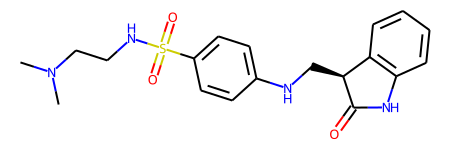

In [8]:
DrawingOptions.includeAtomNumbers=True


refmol = copy.deepcopy(mols[molid])

# Visualization
mol2D = copy.deepcopy(refmol)
mol2D.Compute2DCoords()
mol2D

In [9]:
def cut(mol):
    """
    Original source:
        Project: guacamol_baselines
        Author: BenevolentAI
        File: crossover.py
        License: MIT License
    """
    if not mol.HasSubstructMatch(Chem.MolFromSmarts('[*]-;!@[*]')):
        return None

    # List of atom pairs matching SMARTS pattern
    bis = mol.GetSubstructMatches(Chem.MolFromSmarts('[*]-;!@[*]'))  # single bond not in ring

    fragments = []
    for b in bis:
        # Bond between atom pair
        bs = [mol.GetBondBetweenAtoms(b[0], b[1]).GetIdx()]

        #f = Chem.FragmentOnBonds(mol, bs, addDummies=True, dummyLabels=[(1, 1)])
        f = Chem.FragmentOnBonds(mol, bs, addDummies=False, dummyLabels=[(1, 1)])

        try:
            # Pair of fragments
            mols = Chem.GetMolFrags(f, asMols=True, sanitizeFrags=True)

            # Look for fragments bigger than one heteroatom
            if mols[0].GetNumHeavyAtoms() > 1 and mols[1].GetNumHeavyAtoms() > 1:
                fragments.append(mols)
        except ValueError:
            fragments.appen(None)

    return fragments


In [10]:
# Cut fragments from original molecule (in 3D), not mol1 (in 2D)
frags = cut(refmol)

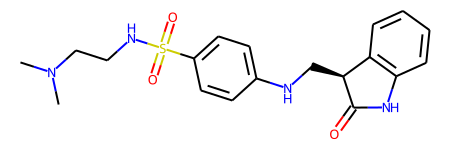

In [11]:
df = pd.DataFrame(frags, columns=["frag1", "frag2"])
df["frag1_smiles"] = df["frag1"].apply(Chem.MolToSmiles)
df["frag2_smiles"] = df["frag2"].apply(Chem.MolToSmiles)

PandasTools.AddMoleculeColumnToFrame(df, "frag1_smiles", "frag1_2D")
PandasTools.AddMoleculeColumnToFrame(df, "frag2_smiles", "frag2_2D")

# Show reference before printing out dataframe
mol2D

,frag1,frag2,frag1_2D,frag2_2D
0,,,,
1,,,,
2,,,,
3,,,,
4,,,,
5,,,,
6,,,,
7,,,,

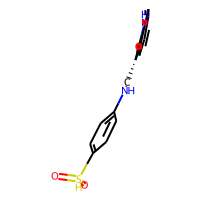
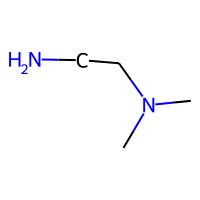
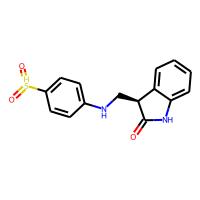
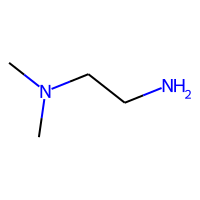
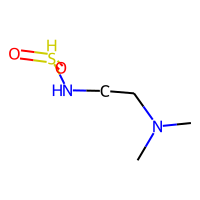
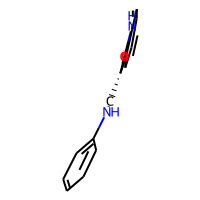
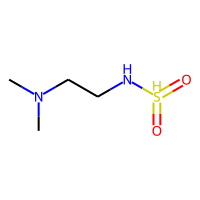
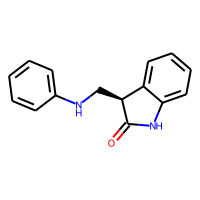
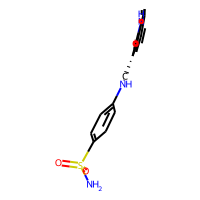
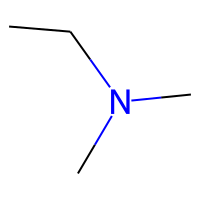
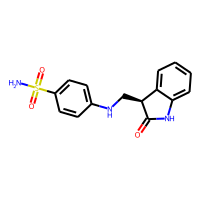
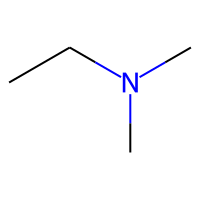
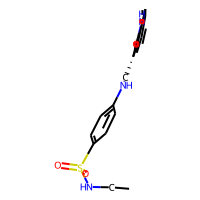
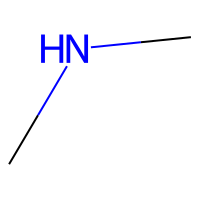
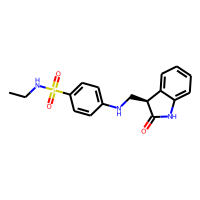
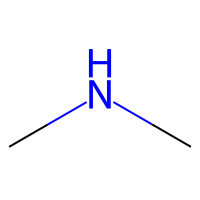
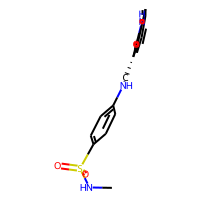
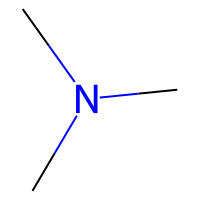
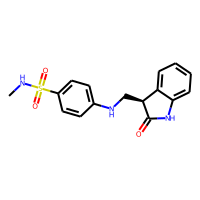
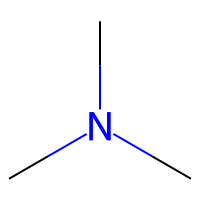
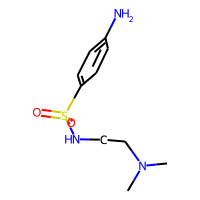
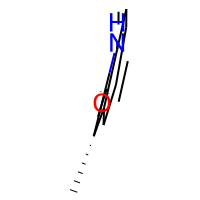
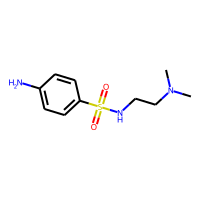
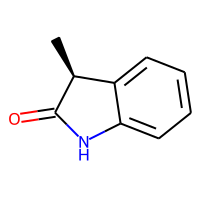
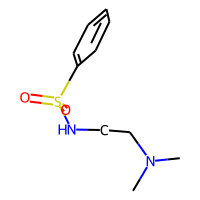
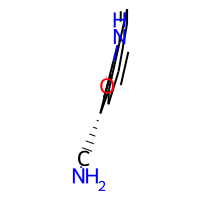
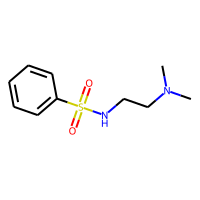
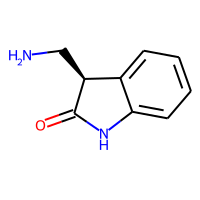
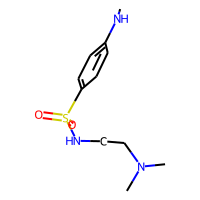
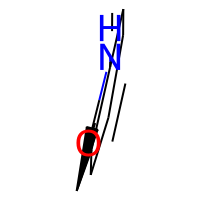
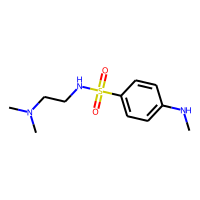
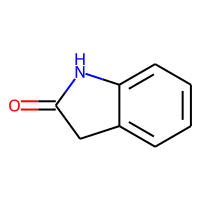

In [12]:
# Check df is still 3D
df.drop(columns=["frag1_smiles", "frag2_smiles"])

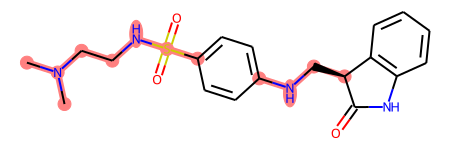

In [13]:
# Check mol1 is 3D
mol2D = copy.deepcopy(refmol)
mol2D.Compute2DCoords()
mol2D

In [14]:
rng = default_rng(42)

def random_translate_and_rotate(mol):
    # Normalised axis of rotation
    u = rng.uniform(size=3)
    u /= np.linalg.norm(u)
    
    # Angle of rotation
    a = rng.uniform(low=0, high=2*np.pi)
    
    # Rotation
    r = R.from_rotvec(u * a)
    
    # Translation
    t = rng.uniform(low=-1, high=1, size=3)
    
    # Affine tranformation
    A = np.zeros((4,4))
    A[:3,:3] = r.as_matrix()
    A[:3,3] = t
    A[3,3] = 1
    
    rdMolTransforms.TransformConformer(mol.GetConformer(0), A)

In [15]:
testmol = Chem.MolFromSmiles("c1ccccc1")
testmolh = Chem.AddHs(testmol)
AllChem.EmbedMolecule(testmolh)

0

In [16]:
def show(index):
    p = py3Dmol.view()
    p.addModel(Chem.MolToMolBlock(testmolh), 'sdf')
    random_translate_and_rotate(testmolh)
    p.addModel(Chem.MolToMolBlock(testmolh), 'sdf')

    p.setStyle({"model": 0}, {'stick':{'colorscheme':'lightgreyCarbon'}})
    p.setStyle({"model": 1}, {'stick':{'colorscheme':'redCarbon'}})

    p.zoomTo()
    
    return p

_ = widgets.interact(show, index=widgets.IntSlider(min=0, max=100, step=1, value=0))

interactive(children=(IntSlider(value=0, description='index'), Output()), _dom_classes=('widget-interact',))

In [17]:
for idx, row in df.iterrows():
    mol1 = row["frag1"]
    mol2 = row["frag2"]
    
    # Randomly translate and rotate fragments
    random_translate_and_rotate(mol1)
    random_translate_and_rotate(mol2)

    with Chem.SDWriter(os.path.join(path, f"frag_{idx}_1.sdf")) as w:
        w.write(mol1, confId=0)

    with Chem.SDWriter(os.path.join(path, f"frag_{idx}_2.sdf")) as w:
        w.write(mol2, confId=0)

In [18]:
n_frags = len(frags)
n_frags_minus_one = n_frags - 1
n_frags

8

In [19]:
!ls ligands/CDK2 | grep frag

allfrags.sdf
frag_0_1.pcd
frag_0_1.sdf
frag_0_2.pcd
frag_0_2.sdf
frag_1_1.pcd
frag_1_1.sdf
frag_1_2.pcd
frag_1_2.sdf
frag_2_1.pcd
frag_2_1.sdf
frag_2_2.pcd
frag_2_2.sdf
frag_3_1.pcd
frag_3_1.sdf
frag_3_2.pcd
frag_3_2.sdf
frag_4_1.pcd
frag_4_1.sdf
frag_4_2.pcd
frag_4_2.sdf
frag_5_1.pcd
frag_5_1.sdf
frag_5_2.pcd
frag_5_2.sdf
frag_6_1.pcd
frag_6_1.sdf
frag_6_2.pcd
frag_6_2.sdf
frag_7_1.pcd
frag_7_1.sdf
frag_7_2.pcd
frag_7_2.sdf


## Fragment Alignment with SENSAAS

Concatenate all fragment SDF files to be aligned to the original file using `meta-sensaas.py`:

In [20]:
%%bash
cat ligands/CDK2/frag_?_?.sdf > ligands/CDK2/allfrags.sdf

In [21]:
reffile = files[molid].replace(".pcd", ".sdf")
reffile

'ligands/CDK2/4fkt_B_48K_tran.sdf'

In [22]:
%%bash  -s {reffile}
export PATH=${PWD}/../../sensaas:${PATH}
python ../../sensaas/meta-sensaas.py ${1} ligands/CDK2/allfrags.sdf 

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

Traceback (most recent call last):
  File "../../sensaas/sensaas.py", line 235, in <module>
    tran=gcicp_registration(source_pcd,target_pcd,threshold,output,pcds2,pcds3,pcds4,pcdt2,pcdt3,pcdt4,Slabel2,Slabel3,Slabel4, args.voxel_sizes)
  File "/biggin/b195/lina3015/Documents/git/sensaas/GCICP.py", line 75, in gcicp_registration
    result_cicp = colored_point_cloud(source_down,target_down,globaltran,voxel_size)
  File "/biggin/b195/lina3015/Documents/git/sensaas/GCICP.py", line 48, in colored_point_cloud
    relative_rmse = 1e-6, max_iteration = max_iter))
RuntimeError: [Open3D Error] (virtual Eigen::Matrix4d open3d::pipelines::registration::TransformationEstimationForColoredICP::ComputeTransformation(const open3d::geometry::PointCloud&, const open3d::geometry::PointCloud&, const CorrespondenceSet&) const) /home/runner/work/Open3D/Open3D/cpp/open3d/pipelines/registration/ColoredICP.cpp:124: No correspondences found between source and target pointcloud.

Traceback (most recent call la

In [23]:
sensaasfrags = [mol for mol in Chem.SDMolSupplier("catsensaas.sdf")]

def update(index=0):
    p = py3Dmol.view()
    
    m = sensaasfrags[index]
    if m is not None:
        p.addModel(Chem.MolToMolBlock(m), 'sdf')
        p.addModel(Chem.MolToMolBlock(refmol), 'sdf')

    p.setStyle({"model": 1}, {'stick':{'colorscheme':'lightgreyCarbon'}})
    p.setStyle({"model": 0}, {'stick':{'colorscheme':'redCarbon'}})

    p.zoomTo()

    return p
    
_ = widgets.interact(update, index=widgets.IntSlider(min=0, max=len(sensaasfrags)-1, step=1, value=0))

RDKit ERROR: [15:00:25] ERROR: CTAB version string invalid at line 251
RDKit ERROR: [15:00:25] ERROR: moving to the beginning of the next molecule
RDKit ERROR: [15:00:25] ERROR: CTAB version string invalid at line 312
RDKit ERROR: [15:00:25] ERROR: moving to the beginning of the next molecule
RDKit ERROR: [15:00:25] ERROR: CTAB version string invalid at line 371


interactive(children=(IntSlider(value=0, description='index', max=16), Output()), _dom_classes=('widget-intera…

## Fragment Alignment with `libmolgrid` Densities

In [24]:
%%bash -s "$path" "$n_frags_minus_one"

# Python variable path passed to bash
# Can be accessed with $1

# Python variable n_frags passed to bash
# Can be accessed with $2

# Unfortunately molgrid does not work well with pybel
# molgrid_to_pcd needs to run within a Singularity container
# (RDKit and molgrid compiled from source!)
# See https://github.com/gnina/libmolgrid/issues/62

for FRAG in $(seq 0 $2)
do
    singularity run --nv --app python ../development/densitymatch.sif \
        ../molgrid_to_pcd.py ${PWD}/${1}/frag_${FRAG}_1.sdf -o ${PWD}/${1}/frag_${FRAG}_1.pcd \
            --ligmap ${PWD}/../files/ligmap

    singularity run --nv --app python ../development/densitymatch.sif \
        ../molgrid_to_pcd.py ${PWD}/${1}/frag_${FRAG}_2.sdf -o ${PWD}/${1}/frag_${FRAG}_2.pcd \
            --ligmap ${PWD}/../files/ligmap
done

In [25]:
!ls ligands/BRD4 | grep "frag.*\.pcd"

frag_0_1.pcd
frag_0_2.pcd
frag_1_1.pcd
frag_1_2.pcd
frag_2_1.pcd
frag_2_2.pcd
frag_3_1.pcd
frag_3_2.pcd
frag_4_1.pcd
frag_4_2.pcd


In [26]:
fpcds = []
fmols = []

files = [os.path.join(path, f"frag_{nf}_{i}.pcd") for nf in range(n_frags) for i in range(1, 3)]

print(files)

for f in files:
    pcd = o3d.io.read_point_cloud(f)
    fpcds.append(pcd)

    s = Chem.SDMolSupplier(f.replace(".pcd", ".sdf"))
    mol = next(s)
    fmols.append(mol)

print(fpcds)

['ligands/CDK2/frag_0_1.pcd', 'ligands/CDK2/frag_0_2.pcd', 'ligands/CDK2/frag_1_1.pcd', 'ligands/CDK2/frag_1_2.pcd', 'ligands/CDK2/frag_2_1.pcd', 'ligands/CDK2/frag_2_2.pcd', 'ligands/CDK2/frag_3_1.pcd', 'ligands/CDK2/frag_3_2.pcd', 'ligands/CDK2/frag_4_1.pcd', 'ligands/CDK2/frag_4_2.pcd', 'ligands/CDK2/frag_5_1.pcd', 'ligands/CDK2/frag_5_2.pcd', 'ligands/CDK2/frag_6_1.pcd', 'ligands/CDK2/frag_6_2.pcd', 'ligands/CDK2/frag_7_1.pcd', 'ligands/CDK2/frag_7_2.pcd']
[PointCloud with 719 points., PointCloud with 218 points., PointCloud with 323 points., PointCloud with 558 points., PointCloud with 762 points., PointCloud with 189 points., PointCloud with 841 points., PointCloud with 113 points., PointCloud with 810 points., PointCloud with 158 points., PointCloud with 583 points., PointCloud with 339 points., PointCloud with 518 points., PointCloud with 381 points., PointCloud with 631 points., PointCloud with 319 points.]


In [27]:
def align_frag_and_show(cidx, idx):
    """
    Align given conformer with original BRD4 ligand.
    """
    pcd1, pcd2 = fpcds[cidx], pcds[idx]
    mol1, mol2 = fmols[cidx], mols[idx]
    
    fit, cfit, tran = fit_and_score((pcd1, pcd2), voxel_size=0.5, threshold=0.5)

    print(cfit.fitness)

    # Get coordinates to transform
    coords = mol1.GetConformer(0).GetPositions()

    # Augment coordinates with ones
    coords_aug = np.ones((coords.shape[0], 4))
    coords_aug[:,:3] = coords

    # Compute new (transformed) coordinates
    coords_new = np.matmul(tran, coords_aug.T)[:3,:].T

    # Add new coordinates as conformer
    n_atoms = mol1.GetNumAtoms()
    conf = Chem.Conformer(n_atoms)
    for i in range(n_atoms):
        conf.SetAtomPosition(i, coords_new[i,:])

    _ = mol1.AddConformer(conf, assignId=True)

    # Create view
    p = py3Dmol.view()
    p.addModel(Chem.MolToMolBlock(mol1, confId=0),'sdf')
    p.addModel(Chem.MolToMolBlock(mol1, confId=1),'sdf')
    p.addModel(Chem.MolToMolBlock(mol2, confId=0),'sdf')

    p.setStyle({"model": 0}, {'stick':{'colorscheme':'lightgreyCarbon'}})
    p.setStyle({"model": 1}, {'stick':{'colorscheme':'redCarbon'}})
    p.setStyle({"model": 2}, {'stick':{'colorscheme':'greyCarbon'}})

    p.zoomTo()

    return p

In [28]:
align_frag_and_show(0, molid)

0.717663421418637


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [29]:
align_frag_and_show(2, molid)

0.7956656346749226


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [30]:
align_frag_and_show(3, molid)

0.946236559139785


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [31]:
def showaligned(index=0):
    return align_frag_and_show(index, molid)
    
_ = widgets.interact(showaligned, index=widgets.IntSlider(min=0, max=len(fmols)-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='index', max=15), Output()), _dom_classes=('widget-intera…